# Connect Three 

The primary description of this coursework is available on the CM20252 Moodle page. This is the Jupyter notebook you must complete and submit to receive marks. This notebook adds additional detail to the coursework specification but does not repeat the information that has already been provided there. 

You must follow all instructions given in this notebook precisely.

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing. Remember to save your work regularly.

__You will develop players for Connect-Three on a grid that is 5 columns wide and 3 rows high. An example is shown below showing a win for Player Red.__

<img src="images/connect3.png" style="width: 200px;"/>

## Preliminaries

For your reference, below is a visual depiction of the agent-environment interface in reinforcment learning. The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$. 

<img src="images/agent-environment.png" style="width: 500px;"/>

<br><br><br>

Below, we provide some code that will be useful for implementing parts of this interface. You are not obligated to use this code; please feel free to develop your own code from scratch. 

### Code details

We provide a `Connect` class that you can use to simulate Connect-Three games. The following cells in this section will walk you through the basic usage of this class by playing a couple of games.

We import the `connect` module and create a Connect-Three environmnet called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the `Connect` object will regularly print the progress of the game. This is useful for getting to know the provided code, debugging your code, or if you just want to play around. You will want to set `verbose=False` when you run hundreds of episodes to complete the marked exercises.

This `Connect` environment uses the strings `'o'` and `'x'` instead of different disk colors in order to distuingish between the two players.

Before we start a game, we should call the `reset()` method. This method cleans the board and resets other state variables. The `first_player` argument can be specified (`'o'` or `'x'`) to deterministically choose the starting player. It defaults to `"random"`, in which case each player starts the game with probability of $\frac{1}{2}$.

In [ ]:
import connect
env = connect.Connect(verbose=True)
env.reset(first_player='o')

We can interact with the environment using the `act()` method. This method takes an `action` as input and computes the response of the environment. An action is defined as the column index that a disk is dropped into.

In [ ]:
env.act(action=2)

The `act()` method inserts a disk into the specified column. 

If we want to change the player on move, we can do so by using the `change_turn()` method. We can check whose turn it is by accessing the `.player_at_turn` attribute.

In [ ]:
print("Current player at turn:", env.player_at_turn)
env.change_turn()
print("Current player at turn:", env.player_at_turn)

# Drop another disk into the same centre column.
env.act(action=2)

Because we set `verbose=True`, the grid is printed each time we call the `act()` method. This grid is stored as a two-dimensional numpy array in the connect class and you can easily access by calling...

In [ ]:
current_grid = env.grid
print(current_grid)
# Notice that the grid now appears to be "upside down" because numpy arrays are printed from "top to bottom".

In [ ]:
# Let's make another move.
env.change_turn()
env.act(action=2)

If we make another move with `act(action=2)`, the environment will throw an error because that column is already filled.

In [ ]:
# This cell should throw an error!
env.change_turn()
env.act(action=2)

The attribute `.available_actions` contains a numpy array of all not yet filled columns.

In [ ]:
print(env.available_actions)
# Column index '2' is missing because this column is already filled

The `Connect` class contains a method called `was_winning_move()` that checks whether the last move won the game (returns `True`) or not (returns `False`). 

In [ ]:
# Obviously the game has not yet been won by any player.
print("Winning move?", env.was_winning_move()) 

# Make some moves
env.act(action=3)
env.change_turn()
env.act(action=1)
env.change_turn()
env.act(action=3)
env.change_turn()
env.act(action=0)

# Check again whether a player has won the game.
print("Winning move?", env.was_winning_move()) 

Finally, the `Connect` class contains a method called `grid_is_full()` that checks whether the grid still contains empty slots. You can use this method to check whether the game is a draw.

Feel free to modify existing or add new methods to the `Connect` class.

## Part 1: Q-learning

Your opponent is always the first player. Your agent is always the second player.

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>

Prepare a **learning curve** following the directions below. We refer to this as Plot 1.

After $n$ steps of interaction with the environment, play $m$ games with the current policy of the agent (without modifying the policy). Think of this as interrupting the agent for a period of time to test how well it has learned so far. Your plot should show the total score obtained in these $m$ games as a function of $n, 2n, 3n, … kn$. The choices of $n$ and $k$ are up to you. They should be reasonable values that demonstrate the efficiency of the learning and how well the agent learns to play the game eventually. Use $m=10$. 

This plot should show the mean performance of $a$ agents, not the performance of a single agent. Because of the stochasticity in the environment, you will obtain two different learning curves from two different agents even though they are using exactly the same algorithm. We suggest setting $a$ to 30 or higher.

Present a single mean learning curve with your choice of parameters $\epsilon$ and $\alpha$. The plot should also show (as a baseline) the mean performance of a random agent that does not learn but chooses actions uniformly randomly from among the legal actions. Label this line “Random Agent”. 

Please include this plot as a static figure in the appropriate cell below. You can look at the source code of this markdown cell to find out how to embed figures using html or you can use drag & drop. If you link to locally stored images, make sure to include those in your submission.

In [ ]:
import connect
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import RandomAgent as ra

K=200
class Environment:
    def __init__(self):
        self.game=connect.Connect(verbose=False)
        self.game.reset(first_player='o')
    
    def choiceRandAction(self):
        available=self.game.available_actions
        return available[random.randint(0,len(available.tolist())-1)]
    
    def makeRandAction(self):
        action=self.choiceRandAction()
        self.game.act(action)

    def makeEnvAction(self,isfirst):
        if isfirst:
            self.game.reset(first_player='o')
            self.makeRandAction()
            self.game.change_turn()
        else:
            if self.game.was_winning_move('x'):
                self.game.reset(first_player='o')
                self.makeRandAction()
                self.game.change_turn()
            elif self.game.grid_is_full():#means a draw
                self.game.reset(first_player='o')
                self.makeRandAction()
                self.game.change_turn()
            else:
                self.makeRandAction()
                self.game.change_turn()

            
class MemoryUnit:
    def __init__(self,state):
        self.state=state
        self.actionValues={0:0,1:0,2:0,3:0,4:0}

    def getmaxAction(self,available_actions):
        maxvalue=-1
        maxaction=-1
        for action in available_actions:
            if self.actionValues[action]>=maxvalue:
                maxvalue=self.actionValues[action]
                maxaction=action
        return maxaction
    
    def getmaxActionValue(self):
        maxvalue=-1
        for action in self.actionValues:
            if self.actionValues[action]>=maxvalue:
                maxvalue=self.actionValues[action]   
        return maxvalue

    def setActionValue(self,action,value):#if there is the memrory about a state,can use this method to update the value of its action 
        self.actionValues[action]=value


class Agent:
    def __init__(self,environment=Environment()):
        self.workmemory={}#previous{'state':xxx,'action':yyy]
        self.longtermmemory=[]#list of MemoryUnit
        self.environment=environment
        self.γ=0.7
        self.α=0.7
        self.ε=0.05
        self.resultlist=[]
    def searchMemory(self,state):#return a MemoryUnit
        result=False
        for unit in self.longtermmemory:
            if self.stateEq(state,unit.state):
                result=unit
                break
        return result
    
    def editMemory(self,MemoryUnit,action,value):
        MemoryUnit.setActionValue(action,value)

    def addMemory(self,state,action,value):#called in the case that when a state first insert into memory
        newMemoryUnit=MemoryUnit(state)
        newMemoryUnit.actionValues[action]=value
        self.longtermmemory.append(newMemoryUnit)

    def stateEq(self,state1,state2):#state is a numpy array
        return (state1==state2).all()

    def getChoiceAction(self):#get a choose action from a given state
        memory=False
        memory=self.searchMemory(self.environment.game.grid)
        if memory==False:
            available_actions=self.environment.game.available_actions.tolist()
            return available_actions[random.randint(0,len(available_actions)-1)]
        else:
            if random.random()>self.ε:
                return memory.getmaxAction(self.environment.game.available_actions.tolist())#########
            else:
                available_actions=self.environment.game.available_actions.tolist()
                return available_actions[random.randint(0,len(available_actions)-1)]
    
    def getNowstate(self):#get the state of the env now
        return self.environment.game.grid
    
    def makeAction(self):
        action=self.getChoiceAction()
        self.workmemory={'state':copy.deepcopy(self.getNowstate()),'action':copy.deepcopy(action)}#let the workmemory be the state-action pair just have made
        self.environment.game.act(action)
        self.environment.game.change_turn()

    def getReward(self):#only deal with the case that the agent action is not a winning move or draw move(that means the enemy have just made a action)
        R=0
        memoryReward=0#init two part of reward
        '''
        if self.environment.game.was_winning_move('o'):
            R=-1
            memoryReward=0
        elif self.environment.game.grid_is_full():
            R=0
            memoryReward=0
        else:
        '''
        R=0
        nowstate=self.getNowstate()
        findMemoryUnit=self.searchMemory(nowstate)
        if findMemoryUnit==False:
            memoryReward=0
        else:
            memoryReward=findMemoryUnit.getmaxActionValue()
        return {'R':R,'memoryreward':memoryReward}


    def learn(self,reward):#learn by init and add memoryUnit into memory or edit existed memoryUnit
        R=reward['R']
        memoreward=reward['memoryreward']
        prevoiusState=self.workmemory['state']
        prevoiusAction=self.workmemory['action']
        findMemoryUnit=self.searchMemory(prevoiusState)
        if findMemoryUnit==False:
            initvalue=self.α*(R+self.γ*memoreward)
            self.addMemory(prevoiusState,prevoiusAction,initvalue)
        else:
            oldvalue=findMemoryUnit.actionValues[prevoiusAction]
            newvalue=(1-self.α)*oldvalue+self.α*(R+self.γ*memoreward)
            self.editMemory(findMemoryUnit,prevoiusAction,newvalue)

    def interact(self):#a interact include decide a action,make the action,the action of env(enemy),and learn from reward.
        if self.environment.game.grid_is_full():#the action that enemy draw
            reward={'R':0,'memoryreward':0}
            self.learn(reward)
            self.environment.game.reset(first_player='o')
            self.environment.makeEnvAction(True)

        self.makeAction()

        if self.environment.game.was_winning_move('x'):
            reward={'R':1,'memoryreward':0}
            self.learn(reward)
            self.environment.makeEnvAction(True)
        elif self.environment.game.grid_is_full():#means a draw
            reward={'R':0,'memoryreward':0}
            self.learn(reward)
            self.environment.makeEnvAction(True)
        else:
            self.environment.makeEnvAction(False)
            if self.environment.game.grid_is_full():#the action that enemy draw
                reward={'R':0,'memoryreward':0}
                self.learn(reward)
                self.environment.game.reset(first_player='o')
                self.environment.makeEnvAction(True)
            elif self.environment.game.was_winning_move('o'):
                reward={'R':-1,'memoryreward':0}
                self.learn(reward)
                self.environment.game.reset(first_player='o')
                self.environment.makeEnvAction(True)
            else:
                reward=self.getReward()
                self.learn(reward)

    def play_a_game(self):#return the result of the game(win:1,lose:-1,draw:0)
        def judgeGameState():
            if self.environment.game.player_at_turn=='o' and self.environment.game.was_winning_move('x'):
                return win#player_at_turn is after a change made by previousActionner,so'o'means previous action is made my agent
            elif self.environment.game.player_at_turn=='x' and  self.environment.game.was_winning_move('o'):
                return lose
            elif self.environment.game.grid_is_full():
                return draw
            else:
                return running

        self.environment.game.reset(first_player='o')
        running=10
        win=1
        lose=-1
        draw=0#four kinds of game states
        step=0
        while(True):
            if step==0:
                isfirst=True
            else:
                isfirst=False
            self.environment.makeEnvAction(isfirst)
            newgamestate=judgeGameState()

            if newgamestate==win:
                return win
            elif newgamestate==lose:
                return lose
            elif newgamestate==draw:
                return draw

            self.makeAction()
            newgamestate=judgeGameState()
  
            if newgamestate==win:
                return win
            elif newgamestate==lose:
                return lose
            elif newgamestate==draw:
                return draw
            step+=1
        
    def trainAndShow(self,k=K,n=20,m=10):
        def play_m_games_and_sum_up():
            summary=0
            newAgent=Agent()
            newAgent.longtermmemory=copy.deepcopy(self.longtermmemory)
            for i in range(m):
                summary=summary+newAgent.play_a_game()
            return summary

        self.environment.game.reset(first_player='o')
        self.environment.makeEnvAction(True)
        for i in range(k):
            for j in range(n):
                self.interact()
            res=play_m_games_and_sum_up()
 #           print(res)
            self.resultlist.append(res)


def draw(resultlist,randlist):
    x=list(range(len(resultlist))) 
    plt.figure()  
    plt.plot(x,resultlist,'r', label='Q-learning')
    plt.plot(x,randlist,'b',label='Random Agent')
    plt.xlabel("k")  
    plt.ylabel("value")  
    plt.savefig("return.jpg")  
 
agentnum=30

agentlsit=[]
randomagentlist=[]

for i in range(agentnum):
    agent=Agent()#####
    agentlsit.append(agent)
for agent in agentlsit:
    agent.trainAndShow()

for i in range(agentnum):
    agent=ra.randomAgent()#####
    randomagentlist.append(agent)
for agent in randomagentlist:
    agent.trainAndShow()

def sumagentlistresult():
    retlist=[]
    for i in range(K):
        retlist.append(0)
    for agent in agentlsit:
        retlist = map(lambda x, y: x + y, retlist,agent.resultlist)
    retlist=list(map(lambda x:x/agentnum,retlist))
    return retlist

def sumrandomagentlistresult():
    retlist=[]
    for i in range(K):
        retlist.append(0)
    for agent in randomagentlist:
        retlist = map(lambda x, y: x + y, retlist,agent.resultlist)
    retlist=list(map(lambda x:x/agentnum,retlist))
    return retlist

retlist=sumagentlistresult()
randomlist=sumrandomagentlistresult()
draw(retlist,randomlist)




(A) [continued} Insert your static learning curve here (Plot 1).
<img src="images/part1image.jpg" style="width: 600px;"/>


(B) In 3 sentences or less, explain your conclusions from the plot above. How close does your (average) agent get to the best possible level of performance? How efficiently does your (average) agent learn? 

I select the section(0-200) in witch the agent learn most fast. In turn 400-500 the agent will get to the best possible level of performance,about score 6.5。it is more efficent than i think.

(C) In five sentences or less, explain the key aspects of your implementation. How many state-action pairs do you represent in your Q-table? Describe and justify your settings of $\alpha$ and $\epsilon$. Are there any things you tried out that are not in your final implementation?

In the beginning of the training,there is nothing in the longtern memory of the agent while it will add state-action pair when experience it.and if we look up the memory of a state that not exist yet,we will just get a random choice.so we don't need to search every available state in the memory.I have tried to code the state to a unique number so that i can store it in memory using more efficient data structure than list. 

(D) In the cell below, make it possible for us to produce from scratch a learning curve similar to Plot 1 but for a single agent, for a $k$ value of your own choosing. You do not need to include the baseline for random play.  This code should run in less than 30 seconds (ours runs in 2 seconds). 


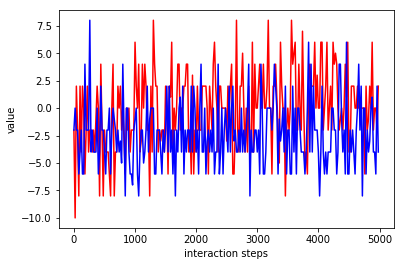

In [16]:
import connect
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import RandomAgent as ra

K=200
class Environment:
    def __init__(self):
        self.game=connect.Connect(verbose=False)
        self.game.reset(first_player='o')
    
    def choiceRandAction(self):
        available=self.game.available_actions
        return available[random.randint(0,len(available.tolist())-1)]
    
    def makeRandAction(self):
        action=self.choiceRandAction()
        self.game.act(action)

    def makeEnvAction(self,isfirst):
        if isfirst:
            self.game.reset(first_player='o')
            self.makeRandAction()
            self.game.change_turn()
        else:
            if self.game.was_winning_move('x'):
                self.game.reset(first_player='o')
                self.makeRandAction()
                self.game.change_turn()
            elif self.game.grid_is_full():#means a draw
                self.game.reset(first_player='o')
                self.makeRandAction()
                self.game.change_turn()
            else:
                self.makeRandAction()
                self.game.change_turn()

            
class MemoryUnit:
    def __init__(self,state):
        self.state=state
        self.actionValues={0:0,1:0,2:0,3:0,4:0}

    def getmaxAction(self,available_actions):
        maxvalue=-1
        maxaction=-1
        for action in available_actions:
            if self.actionValues[action]>=maxvalue:
                maxvalue=self.actionValues[action]
                maxaction=action
        return maxaction
    
    def getmaxActionValue(self):
        maxvalue=-1
        for action in self.actionValues:
            if self.actionValues[action]>=maxvalue:
                maxvalue=self.actionValues[action]   
        return maxvalue

    def setActionValue(self,action,value):#if there is the memrory about a state,can use this method to update the value of its action 
        self.actionValues[action]=value


class Agent:
    def __init__(self,environment=Environment()):
        self.workmemory={}#previous{'state':xxx,'action':yyy]
        self.longtermmemory=[]#list of MemoryUnit
        self.environment=environment
        self.γ=0.7
        self.α=0.7
        self.ε=0.05
        self.resultlist=[]
    def searchMemory(self,state):#return a MemoryUnit
        result=False
        for unit in self.longtermmemory:
            if self.stateEq(state,unit.state):
                result=unit
                break
        return result
    
    def editMemory(self,MemoryUnit,action,value):
        MemoryUnit.setActionValue(action,value)

    def addMemory(self,state,action,value):#called in the case that when a state first insert into memory
        newMemoryUnit=MemoryUnit(state)
        newMemoryUnit.actionValues[action]=value
        self.longtermmemory.append(newMemoryUnit)

    def stateEq(self,state1,state2):#state is a numpy array
        return (state1==state2).all()

    def getChoiceAction(self):#get a choose action from a given state
        memory=False
        memory=self.searchMemory(self.environment.game.grid)
        if memory==False:
            available_actions=self.environment.game.available_actions.tolist()
            return available_actions[random.randint(0,len(available_actions)-1)]
        else:
            if random.random()>self.ε:
                return memory.getmaxAction(self.environment.game.available_actions.tolist())#########
            else:
                available_actions=self.environment.game.available_actions.tolist()
                return available_actions[random.randint(0,len(available_actions)-1)]
    
    def getNowstate(self):#get the state of the env now
        return self.environment.game.grid
    
    def makeAction(self):
        action=self.getChoiceAction()
        self.workmemory={'state':copy.deepcopy(self.getNowstate()),'action':copy.deepcopy(action)}#let the workmemory be the state-action pair just have made
        self.environment.game.act(action)
        self.environment.game.change_turn()

    def getReward(self):#only deal with the case that the agent action is not a winning move or draw move(that means the enemy have just made a action)
        R=0
        memoryReward=0#init two part of reward
        '''
        if self.environment.game.was_winning_move('o'):
            R=-1
            memoryReward=0
        elif self.environment.game.grid_is_full():
            R=0
            memoryReward=0
        else:
        '''
        R=0
        nowstate=self.getNowstate()
        findMemoryUnit=self.searchMemory(nowstate)
        if findMemoryUnit==False:
            memoryReward=0
        else:
            memoryReward=findMemoryUnit.getmaxActionValue()
        return {'R':R,'memoryreward':memoryReward}


    def learn(self,reward):#learn by init and add memoryUnit into memory or edit existed memoryUnit
        R=reward['R']
        memoreward=reward['memoryreward']
        prevoiusState=self.workmemory['state']
        prevoiusAction=self.workmemory['action']
        findMemoryUnit=self.searchMemory(prevoiusState)
        if findMemoryUnit==False:
            initvalue=self.α*(R+self.γ*memoreward)
            self.addMemory(prevoiusState,prevoiusAction,initvalue)
        else:
            oldvalue=findMemoryUnit.actionValues[prevoiusAction]
            newvalue=(1-self.α)*oldvalue+self.α*(R+self.γ*memoreward)
            self.editMemory(findMemoryUnit,prevoiusAction,newvalue)

    def interact(self):#a interact include decide a action,make the action,the action of env(enemy),and learn from reward.
        if self.environment.game.grid_is_full():#the action that enemy draw
            reward={'R':0,'memoryreward':0}
            self.learn(reward)
            self.environment.game.reset(first_player='o')
            self.environment.makeEnvAction(True)

        self.makeAction()

        if self.environment.game.was_winning_move('x'):
            reward={'R':1,'memoryreward':0}
            self.learn(reward)
            self.environment.makeEnvAction(True)
        elif self.environment.game.grid_is_full():#means a draw
            reward={'R':0,'memoryreward':0}
            self.learn(reward)
            self.environment.makeEnvAction(True)
        else:
            self.environment.makeEnvAction(False)
            if self.environment.game.grid_is_full():#the action that enemy draw
                reward={'R':0,'memoryreward':0}
                self.learn(reward)
                self.environment.game.reset(first_player='o')
                self.environment.makeEnvAction(True)
            elif self.environment.game.was_winning_move('o'):
                reward={'R':-1,'memoryreward':0}
                self.learn(reward)
                self.environment.game.reset(first_player='o')
                self.environment.makeEnvAction(True)
            else:
                reward=self.getReward()
                self.learn(reward)

    def play_a_game(self):#return the result of the game(win:1,lose:-1,draw:0)
        def judgeGameState():
            if self.environment.game.player_at_turn=='o' and self.environment.game.was_winning_move('x'):
                return win#player_at_turn is after a change made by previousActionner,so'o'means previous action is made my agent
            elif self.environment.game.player_at_turn=='x' and  self.environment.game.was_winning_move('o'):
                return lose
            elif self.environment.game.grid_is_full():
                return draw
            else:
                return running

        self.environment.game.reset(first_player='o')
        running=10
        win=1
        lose=-1
        draw=0#four kinds of game states
        step=0
        while(True):
            if step==0:
                isfirst=True
            else:
                isfirst=False
            self.environment.makeEnvAction(isfirst)
            newgamestate=judgeGameState()

            if newgamestate==win:
                return win
            elif newgamestate==lose:
                return lose
            elif newgamestate==draw:
                return draw

            self.makeAction()
            newgamestate=judgeGameState()
  
            if newgamestate==win:
                return win
            elif newgamestate==lose:
                return lose
            elif newgamestate==draw:
                return draw
            step+=1
        
    def trainAndShow(self,k=K,n=20,m=10):
        def play_m_games_and_sum_up():
            summary=0
            newAgent=Agent()
            newAgent.longtermmemory=copy.deepcopy(self.longtermmemory)
            for i in range(m):
                summary=summary+newAgent.play_a_game()
            return summary

        self.environment.game.reset(first_player='o')
        self.environment.makeEnvAction(True)
        for i in range(k):
            for j in range(n):
                self.interact()
            res=play_m_games_and_sum_up()
 #           print(res)
            self.resultlist.append(res)


def draw(resultlist,randlist):
    x=[i*20 for i in (range(len(resultlist)))]
    plt.figure()  
    plt.plot(x,resultlist,'r', label='Q-learning')
    plt.plot(x,randlist,'b',label='Random Agent')
    plt.xlabel("interaction steps")  
    plt.ylabel("value")  
    plt.show() 
 
agentnum=1

agentlsit=[]
randomagentlist=[]

for i in range(agentnum):
    agent=Agent()#####
    agentlsit.append(agent)
for agent in agentlsit:
    agent.trainAndShow(k=250)

for i in range(agentnum):
    agent=ra.randomAgent()#####
    randomagentlist.append(agent)
for agent in randomagentlist:
    agent.trainAndShow(k=250)

def sumagentlistresult():
    retlist=[]
    for i in range(250):
        retlist.append(0)
    for agent in agentlsit:
        retlist = map(lambda x, y: x + y, retlist,agent.resultlist)
    retlist=list(map(lambda x:x/agentnum,retlist))
    return retlist

def sumrandomagentlistresult():
    retlist=[]
    for i in range(250):
        retlist.append(0)
    for agent in randomagentlist:
        retlist = map(lambda x, y: x + y, retlist,agent.resultlist)
    retlist=list(map(lambda x:x/agentnum,retlist))
    return retlist

retlist=sumagentlistresult()
randomlist=sumrandomagentlistresult()
draw(retlist,randomlist)




## Part 2A
 
Using the minimax policy you computed, answer the following question: The first player (Player 1) drops his/her first disk into column 2 (counting from the left). Consider the resulting state, shown in the following code cell. 

In [ ]:
env = connect.Connect(verbose=False)
env.reset(first_player='o')
env.act(action=1)
print(env.grid[::-1])

What is the Minimax Value of this state for Player 2? That is, assuming an optimal opponent, does the Minimax Policy expect to win the game (value = 1), lose the game (value = –1), or end the game in a draw (value = 0)? Please state your answer as a number.    

* The code cell below should compute this value and assign it to a variable called `state_value`.
* Count the number of branches of the game tree that were examined and assign this number to a variable called `num_branches`.

In [10]:

import connect
import numpy as np 
import copy
import random
import RandomAgent as ra
import matplotlib.pyplot as plt  

K=200
env = connect.Connect(verbose=False)
env.reset(first_player='o')
env.act(action=1)
print(env.grid[::-1])
env.change_turn()

class Environment:
    def __init__(self):
        self.game=connect.Connect(verbose=False)
        self.game.reset(first_player='o')
    
    def choiceRandAction(self):
        available=self.game.available_actions
        return available[random.randint(0,len(available.tolist())-1)]
    
    def makeRandAction(self):
        action=self.choiceRandAction()
        self.game.act(action)

    def makeEnvAction(self,isfirst):
        if isfirst:
            self.game.reset(first_player='o')
            self.makeRandAction()
            self.game.change_turn()
        else:
            if self.game.was_winning_move('x'):
                self.game.reset(first_player='o')
                self.makeRandAction()
                self.game.change_turn()
            elif self.game.grid_is_full():#means a draw
                self.game.reset(first_player='o')
                self.makeRandAction()
                self.game.change_turn()
            else:
                self.makeRandAction()
                self.game.change_turn()


class minimaxAgent:
    def __init__(self,environment=Environment()):
        self.environment=environment
        self.resultlist=[]
        self.count=0
    
    def AlphaBetaMinimax(self,recenv,player,alpha,beta):
        previous_player=recenv.game.other_player[player]
        if recenv.game.was_winning_move(previous_player):
            if previous_player=='o':
                self.count+=1
                return {'R':-1,'A':'over'}
            elif previous_player=='x':
                self.count+=1
                return {'R':1,'A':'over'}
        elif recenv.game.grid_is_full():
            self.count+=1
            return {'R':0,'A':'over'}
        else:
            if player=='x':#looking for max
                availableActions=recenv.game.available_actions.copy()
                retaction='init'
                for action in availableActions:
                    newenv=copy.deepcopy(recenv)
                    newenv.game.act(action)
                    newenv.game.change_turn()
                    actionvalue=self.AlphaBetaMinimax(newenv,'o',alpha,beta)['R']
                    if actionvalue>alpha:
                        alpha=actionvalue
                        retaction=action
                    if alpha>=beta:
                        break
                return {'R':alpha,'A':retaction}
            if player=='o':#looking for min
                availableActions=recenv.game.available_actions.copy()
                retaction='init'
                for action in availableActions:
                    newenv=copy.deepcopy(recenv)
                    newenv.game.act(action)
                    newenv.game.change_turn()
                    actionvalue=self.AlphaBetaMinimax(newenv,'x',alpha,beta)['R']
                    if actionvalue<beta:
                        beta=actionvalue
                        retaction=action
                    if beta<=alpha:
                        break
                return {'R':beta,'A':retaction}

    def getChoiceAction(self):
        return self.AlphaBetaMinimax(self.environment,'x',-10,+10)['A']

    def makeAction(self):
        action=self.getChoiceAction()
        self.environment.game.act(action)
        self.environment.game.change_turn()


    def play_a_game(self):#return the result of the game(win:1,lose:-1,draw:0)#############测不出胜负全平！！！！
        def judgeGameState():
            if self.environment.game.player_at_turn=='o' and self.environment.game.was_winning_move('x'):
                return win#player_at_turn is after a change made by previousActionner,so'o'means previous action is made my agent
            elif self.environment.game.player_at_turn=='x' and  self.environment.game.was_winning_move('o'):
                return lose
            elif self.environment.game.grid_is_full():
                return draw
            else:
                return running

        self.environment.game.reset(first_player='o')
        running=10
        win=1
        lose=-1
        draw=0#four kinds of game states
        step=0
        while(True):
            if step==0:
                isfirst=True
            else:
                isfirst=False
            self.environment.makeEnvAction(isfirst)
            newgamestate=judgeGameState()

            if newgamestate==win:
                return win
            elif newgamestate==lose:
                return lose
            elif newgamestate==draw:
                return draw

            self.makeAction()
            newgamestate=judgeGameState()
  
            if newgamestate==win:
                return win
            elif newgamestate==lose:
                return lose
            elif newgamestate==draw:
                return draw
            step+=1
    
    def trainAndShow(self,k=K,n=20,m=10):
        def play_m_games_and_sum_up():
            summary=0
            newminimaxAgent=minimaxAgent()
            for i in range(m):
                summary=summary+newminimaxAgent.play_a_game()
            return summary

        self.environment.game.reset(first_player='o')
        self.environment.makeEnvAction(True)
        for i in range(k):
            res=play_m_games_and_sum_up()
            print(res)
            self.resultlist.append(res)


def draw(resultlist,randlist):
    x=list(range(len(resultlist))) 
    plt.figure()  
    plt.plot(x,resultlist,'r', label='Q-learning')
    plt.plot(x,randlist,'b',label='Random Agent')
    plt.xlabel("k")  
    plt.ylabel("value")  
    plt.savefig("returnminimax.jpg")  
a=minimaxAgent()


e=Environment()
e.game=env          
state_value = a.AlphaBetaMinimax(e,'x',-10,+10)['R']
num_branches = a.count
print(state_value)
print(num_branches)


[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' 'o' ' ' ' ' ' ']]
-1
4855


In [ ]:
# This is an autograded test cell. Do not delete or change, otherwise you will get 
# no marks for this part of the assignment. Please make sure that this cell has 
# access to the variables state_value and num_branches.

## Part 2B
Plot a learning curve similar to the one in Part 1, comparing your Q-learning algorithm, random play, and Minimax play. Assume as before that the opponent always plays first and uses a random policy.

In [17]:
import connect
import numpy as np 
import copy
import random
import RandomAgent as ra
import Qlearning 
import matplotlib.pyplot as plt  


K=200
env = connect.Connect(verbose=False)
env.reset(first_player='o')
env.act(action=1)
print(env.grid[::-1])
env.change_turn()


class Environment:
    def __init__(self):
        self.game=connect.Connect(verbose=False)
        self.game.reset(first_player='o')
    
    def choiceRandAction(self):
        available=self.game.available_actions
        return available[random.randint(0,len(available.tolist())-1)]
    
    def makeRandAction(self):
        action=self.choiceRandAction()
        self.game.act(action)

    def makeEnvAction(self,isfirst):
        if isfirst:
            self.game.reset(first_player='o')
            self.makeRandAction()
            self.game.change_turn()
        else:
            if self.game.was_winning_move('x'):
                self.game.reset(first_player='o')
                self.makeRandAction()
                self.game.change_turn()
            elif self.game.grid_is_full():#means a draw
                self.game.reset(first_player='o')
                self.makeRandAction()
                self.game.change_turn()
            else:
                self.makeRandAction()
                self.game.change_turn()


class minimaxAgent:
    def __init__(self,environment=Environment()):
        self.environment=environment
        self.resultlist=[]
        self.count=0
    
    def AlphaBetaMinimax(self,recenv,player,alpha,beta):
        previous_player=recenv.game.other_player[player]
        if recenv.game.was_winning_move(previous_player):
            if previous_player=='o':
                self.count+=1
                return {'R':-1,'A':'over'}
            elif previous_player=='x':
                self.count+=1
                return {'R':1,'A':'over'}
        elif recenv.game.grid_is_full():
            self.count+=1
            return {'R':0,'A':'over'}
        else:
            if player=='x':#looking for max
                availableActions=recenv.game.available_actions.copy()
                retaction='init'
                for action in availableActions:
                    newenv=copy.deepcopy(recenv)
                    newenv.game.act(action)
                    newenv.game.change_turn()
                    actionvalue=self.AlphaBetaMinimax(newenv,'o',alpha,beta)['R']
                    if actionvalue>alpha:
                        alpha=actionvalue
                        retaction=action
                    if alpha>=beta:
                        break
                return {'R':alpha,'A':retaction}
            if player=='o':#looking for min
                availableActions=recenv.game.available_actions.copy()
                retaction='init'
                for action in availableActions:
                    newenv=copy.deepcopy(recenv)
                    newenv.game.act(action)
                    newenv.game.change_turn()
                    actionvalue=self.AlphaBetaMinimax(newenv,'x',alpha,beta)['R']
                    if actionvalue<beta:
                        beta=actionvalue
                        retaction=action
                    if beta<=alpha:
                        break
                return {'R':beta,'A':retaction}

    def getChoiceAction(self):
        return self.AlphaBetaMinimax(self.environment,'x',-10,+10)['A']

    def makeAction(self):
        action=self.getChoiceAction()
        self.environment.game.act(action)
        self.environment.game.change_turn()


    def play_a_game(self):#return the result of the game(win:1,lose:-1,draw:0)#############测不出胜负全平！！！！
        def judgeGameState():
            if self.environment.game.player_at_turn=='o' and self.environment.game.was_winning_move('x'):
                return win#player_at_turn is after a change made by previousActionner,so'o'means previous action is made my agent
            elif self.environment.game.player_at_turn=='x' and  self.environment.game.was_winning_move('o'):
                return lose
            elif self.environment.game.grid_is_full():
                return draw
            else:
                return running

        self.environment.game.reset(first_player='o')
        running=10
        win=1
        lose=-1
        draw=0#four kinds of game states
        step=0
        while(True):
            if step==0:
                isfirst=True
            else:
                isfirst=False
            self.environment.makeEnvAction(isfirst)
            newgamestate=judgeGameState()

            if newgamestate==win:
                return win
            elif newgamestate==lose:
                return lose
            elif newgamestate==draw:
                return draw

            self.makeAction()
            newgamestate=judgeGameState()
  
            if newgamestate==win:
                return win
            elif newgamestate==lose:
                return lose
            elif newgamestate==draw:
                return draw
            step+=1
    
    def trainAndShow(self,k=K,n=20,m=10):
        def play_m_games_and_sum_up():
            summary=0
            newminimaxAgent=minimaxAgent()
            for i in range(m):
                summary=summary+newminimaxAgent.play_a_game()
            return summary

        self.environment.game.reset(first_player='o')
        self.environment.makeEnvAction(True)
        for i in range(k):
            res=play_m_games_and_sum_up()
            print(res)
            self.resultlist.append(res)


def draw(resultlist,Qlist,randlist):
    x=[i*20 for i in (range(len(resultlist)))]
    plt.figure()  
    plt.plot(x,resultlist,'r', label='minimax')
    plt.plot(x,Qlist,'k',label='Q-learing')
    plt.plot(x,randlist,'b',label='Random Agent')
    plt.xlabel("interaction steps")  
    plt.ylabel("value")  
    plt.savefig("returnminimax.jpg")  


'''
e=Environment()
e.game=env
a=minimaxAgent()
print(a.AlphaBetaMinimax(e,'x',-10,+10))
print(a.count)
'''         
agentnum=1

minimaxagentlsit=[]
randomagentlist=[]
Qagentlist=[]

for i in range(agentnum):
    agent=minimaxAgent()#####
    minimaxagentlsit.append(agent)
for agent in minimaxagentlsit:
    agent.trainAndShow(k=400)

for i in range(agentnum):
    agent=ra.randomAgent()#####
    randomagentlist.append(agent)
for agent in randomagentlist:
    agent.trainAndShow(k=400)

for i in range(agentnum):
    agent=Qlearning.Agent()
    Qagentlist.append(agent)
for agent in Qagentlist:
    agent.trainAndShow(k=400)
def sumagentlistresult():
    retlist=[]
    for i in range(400):
        retlist.append(0)
    for agent in minimaxagentlsit:
        retlist = map(lambda x, y: x + y, retlist,agent.resultlist)
    retlist=list(map(lambda x:x/agentnum,retlist))
    return retlist

def sumrandomagentlistresult():
    retlist=[]
    for i in range(400):
        retlist.append(0)
    for agent in randomagentlist:
        retlist = map(lambda x, y: x + y, retlist,agent.resultlist)
    retlist=list(map(lambda x:x/agentnum,retlist))
    return retlist

def sumQagentlistresult():
    retlist=[]
    for i in range(400):
        retlist.append(0)
    for agent in Qagentlist:
        retlist=map(lambda x,y:x+y,retlist,agent.resultlist)
    retlist=list(map(lambda x:x/agentnum,retlist))
    return retlist
retlist=sumagentlistresult()
randomlist=sumrandomagentlistresult()
Qlist=sumQagentlistresult()
draw(retlist,Qlist,randomlist)



[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' 'o' ' ' ' ' ' ']]


KeyboardInterrupt: 

Explain your findings in 3 or fewer sentences. Which policy is better? Why?

<img src="images/part2image.jpg" style="width: 600px;"/>
the minimax policy is stable,but minimax search will spend a lot of time.Q-learning will cost lot if time to train,but at last we would get a policy that could could be used very 
efficiency.




## Part 3

Using your algorithm, compute the value of the game for your player (recall: your player goes second against a random opponent). The code cell below should compute this value and assign it to a variable called `optimal_policy_value`.

In [12]:
import connect
import numpy as np 
import copy
import random
import math
import RandomAgent as ra
import matplotlib.pyplot as plt  

K=200
env = connect.Connect(verbose=False)
env.reset(first_player='o')
env.act(action=1)
print(env.grid[::-1])
env.change_turn()

class Environment:
    def __init__(self):
        self.game=connect.Connect(verbose=False)
        self.game.reset(first_player='o')
    
    def choiceRandAction(self):
        available=self.game.available_actions
        return available[random.randint(0,len(available.tolist())-1)]
    
    def makeRandAction(self):
        action=self.choiceRandAction()
        self.game.act(action)

    def makeEnvAction(self,isfirst):
        if isfirst:
            self.game.reset(first_player='o')
            self.makeRandAction()
            self.game.change_turn()
        else:
            if self.game.was_winning_move('x'):
                self.game.reset(first_player='o')
                self.makeRandAction()
                self.game.change_turn()
            elif self.game.grid_is_full():#means a draw
                self.game.reset(first_player='o')
                self.makeRandAction()
                self.game.change_turn()
            else:
                self.makeRandAction()
                self.game.change_turn()
            

class MCTNode:
    def __init__(self,state,player):
        self.state=state
        self.player=player
        self.availableActions=state.available_actions
        self.father=None
        self.childdict={}# key为动作，值为子节点
        self.count=0
        self.playerwins={'o':0,'x':0}
        self.C=0.05
    
    def getmaxaction(self):
        maxval=0
        retaction=None
        for key in self.childdict:
            child=self.childdict[key]
            #val=child.playerwins[self.player]/child.count
            val=child.count
            if val>maxval:
                retaction=key
        return retaction
    
    def getstatevalue(self):
        return self.playerwins[self.player]/self.count

    def incwin(self,player):
        self.playerwins[player]=self.playerwins[player]+1


    def backpropagation(self,winner):
        if self.father==None:
            if winner=='draw':
                self.count+=1
            else:
                self.count+=1
                self.incwin(self.player)
        else:
            if winner=='draw':
                self.count+=1
                self.father.backpropagation(winner)
            else:
                self.count+=1
                self.incwin(self.player)
                self.father.backpropagation(winner)
    
    def getUCB(self,player):
        if self.count==0:
            return 0
        else:
            return self.playerwins[player]/self.count+self.C*math.sqrt(math.log(self.father.count)/self.count)
    
    def select(self,player):
        maxval=-1
        thenode=None
        retaction=None
        if self.state.grid_is_full():
            return {'node':self,'action':'draw'}
        elif self.state.was_winning_move(self.state.other_player[self.state.player_at_turn]):
            return {'node':self,'action':self.state.other_player[self.state.player_at_turn]}
        for action in self.availableActions:
            if action in self.childdict:
                child=self.childdict[action]
                childUCB=child.getUCB(player)#################
                if maxval<=childUCB:
                    thenode=child
                    retaction=action
                    maxval=childUCB
            else:
                thenode=self
                retaction=action
                return {'node':thenode,'action':retaction}
        return thenode.select(player)
        
    
    def expansion(self,action):#return the child that new expan
        newstate=copy.deepcopy(self.state)
        newstate.act(action)
        newstate.change_turn()
        newchild=MCTNode(newstate,newstate.player_at_turn)
        newchild.father=self
        self.childdict[action]=newchild
        return newchild
    
    def simulation(self):
        newenv=copy.deepcopy(self.state)
        if newenv.was_winning_move(newenv.other_player[self.player]):
            return newenv.other_player[self.player]
        elif newenv.grid_is_full():
            return 'draw'
        else:
            while(True):
                available=newenv.available_actions
                action=available[random.randint(0,len(available.tolist())-1)]
                newenv.act(action)
                if newenv.was_winning_move(newenv.player_at_turn):
                    return newenv.player_at_turn
                elif newenv.grid_is_full():
                    return 'draw'
                newenv.change_turn()
            


class MCTSAgent:
    def __init__(self,environment=Environment()):
        self.environment=environment
        self.resultlist=[]
    
    def MCTS(self,env,player):
        root=MCTNode(copy.deepcopy(env),player)#the state of tree node is a connect object
        maxturn=300
        count=0
        while(count<maxturn):
            selectresult=root.select(player)
            if selectresult['action']=='draw':
                selectresult['node'].backpropagation('draw')
                count+=1
                continue
            elif selectresult['action']=='o':
                selectresult['node'].backpropagation('o')
                count+=1
                continue
            elif selectresult['action']=='x':
                selectresult['node'].backpropagation('x')
                count+=1
                continue
            nodetoexpan=selectresult['node']
            nodetosimulate=nodetoexpan.expansion(selectresult['action'])
            simulateresult=nodetosimulate.simulation()
            nodetosimulate.backpropagation(simulateresult)
            count+=1
        return {'action':root.getmaxaction(),'statevalue':root.getstatevalue()}
        
        
        

    def getChoiceAction(self):
        return self.MCTS(self.environment.game,self.environment.game.player_at_turn)['action']

    def makeAction(self):
        action=self.getChoiceAction()
        self.environment.game.act(action)
        self.environment.game.change_turn()


    def play_a_game(self):#return the result of the game(win:1,lose:-1,draw:0)#############测不出胜负全平！！！！
        def judgeGameState():
            if self.environment.game.player_at_turn=='o' and self.environment.game.was_winning_move('x'):
                return win#player_at_turn is after a change made by previousActionner,so'o'means previous action is made my agent
            elif self.environment.game.player_at_turn=='x' and  self.environment.game.was_winning_move('o'):
                return lose
            elif self.environment.game.grid_is_full():
                return draw
            else:
                return running

        self.environment.game.reset(first_player='o')
        running=10
        win=1
        lose=-1
        draw=0#four kinds of game states
        step=0
        while(True):
            if step==0:
                isfirst=True
            else:
                isfirst=False
            self.environment.makeEnvAction(isfirst)
            newgamestate=judgeGameState()

            if newgamestate==win:
                return win
            elif newgamestate==lose:
                return lose
            elif newgamestate==draw:
                return draw

            self.makeAction()
            newgamestate=judgeGameState()
  
            if newgamestate==win:
                return win
            elif newgamestate==lose:
                return lose
            elif newgamestate==draw:
                return draw
            step+=1
    
    def trainAndShow(self,k=K,n=20,m=10):
        def play_m_games_and_sum_up():
            summary=0
            newMCTSAgent=MCTSAgent()
            for i in range(m):
                summary=summary+newMCTSAgent.play_a_game()
            return summary

        self.environment.game.reset(first_player='o')
        self.environment.makeEnvAction(True)
        for i in range(k):
            res=play_m_games_and_sum_up()
            print(res)
            self.resultlist.append(res)


def draw(resultlist,randlist):
    x=list(range(len(resultlist))) 
    plt.figure()  
    plt.plot(x,resultlist,'r', label='MCTS')
    plt.plot(x,randlist,'b',label='Random Agent')
    plt.xlabel("k")  
    plt.ylabel("value")  
    plt.savefig("returnMCTS.jpg")  


a=MCTSAgent()
a.environment.game=env
res=a.MCTS(a.environment.game,a.environment.game.player_at_turn)
print(res['action'])
print(res['statevalue'])

optimal_policy_value = res['statevalue']


[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' 'o' ' ' ' ' ' ']]
4
0.9866666666666667


In [ ]:
# This is an autograded test cell. Do not delete or change, otherwise you will get 
# no marks for this part of the assignment. Please make sure that this cell has 
# access to the variable optimal_policy_value.